In [1]:
import torch
import torch.utils.data as data
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

In [2]:
#Import all the necessary libraries
import numpy as np
import os, json
import mplhep as hep
import uproot
import awkward as ak
import hist
from hist import Hist
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [ ]:
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

In [ ]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0) # Get the name of the first GPU (index 0)
    print(f"CUDA device name: {device_name}")
else:
    print("CUDA is not available.")

In [ ]:
gpu = 0
props = torch.cuda.get_device_properties(gpu)

print("Name:", props.name)
print("CUDA capability:", props.major, props.minor)
print("Multiprocessors (SMs):", props.multi_processor_count)
print("Threads per SM:", props.max_threads_per_multi_processor)
print("Total threads:", props.multi_processor_count * props.max_threads_per_multi_processor)
# print("Max threads per block:", props.max_threads_per_block)


# Define Data to PointCloud

In [3]:
class Jet_Dataset(data.Dataset):

    def __init__(self, dataset_path:str, tree_name:str = 'tree', global_features:list = [], \
                 node_features: list = [], edge_features: list = [], classes = {}, knn: int = 5) -> None:

        super().__init__()
        
        
        self.dataset = uproot.open(dataset_path)
        self.tree = self.dataset[tree_name]
        
        self.global_features = global_features
        self.node_features = node_features
        self.edge_features = edge_features
        self.classes = classes
        self.knn = knn
        
        # Define MASKS
        # --- jet-level truth selection: only b (5) and light (0) ---
        self.jet_genmatch_hflav = self.tree['jet_genmatch_hflav'].array()
        is_b     = (self.jet_genmatch_hflav == 5)
        is_light = (self.jet_genmatch_hflav == 0)
        
        #Number of candidates greater than 5
        has_cands = (self.tree["jet_npfcand"].array() > 5)
        
        # final jet mask for dataset
        jet_mask = (has_cands) & (is_b | is_light)
        
        
        #Apply Masks
        tree_array = self.tree.arrays(library="ak")
        
        self.masked_globals = {k: tree_array[k][jet_mask] for k in self.global_features}
        self.masked_nodes = {k: tree_array[k][jet_mask] for k in self.node_features}
        self.masked_edges = {k: tree_array[k][jet_mask] for k in self.edge_features}
        
        self.n_pf_particles = tree_array["jet_npfcand"][jet_mask]
        self.max_n_pf = max(self.n_pf_particles)
        
        #Number of elements in tree
        self.num_entries = len(self.masked_globals[self.global_features[0]])
        
        self.jet_genmatch_hflav = self.jet_genmatch_hflav[jet_mask]
        
        
               
        
    def adj_Matrix(self, edge_feats:list = [], max_no_particles: int =33 , n_pf_particles: int=6, knn: int = 5):
        
        pad_exists = (n_pf_particles < max_no_particles)
        
        deta = edge_feats[0]
        dphi = edge_feats[1]
        
        coords = [] 
        
        # add real nodes
        for i in range(n_pf_particles):
            coords.append([deta[i], dphi[i]])
        
        if pad_exists:
            coords.append([0.0, 0.0])

        coords = np.array(coords)
        M = len(coords)
        
        deta_c = coords[:,0][:,None] - coords[:,0][None,:]
        dphi_c = coords[:,1][:,None] - coords[:,1][None,:]
        dphi_c = (dphi_c + np.pi) % (2*np.pi) - np.pi
        dR = np.sqrt(deta_c**2 + dphi_c**2)
        np.fill_diagonal(dR, np.inf)

        nbrs = np.argsort(dR, axis=1)[:, :knn]

        A_c = np.zeros((M, M), dtype=np.float32)
        for i in range(M):
            for j in nbrs[i]:
                A_c[i, j] = 1.0
                A_c[j, i] = 1.0

        A_full = np.zeros((max_no_particles, max_no_particles), dtype=np.float32)
        A_full[:M, :M] = A_c
        np.fill_diagonal(A_full, 1.0)
        

        return torch.from_numpy(A_full).float()
        
        
        

    def transform_jet_to_point_cloud(self, idx:int) -> dict :
    
        npart = self.n_pf_particles[idx]
        
        jet_feat = np.array([[self.masked_globals[graph][idx] for graph in self.global_features]])
        pfcand_feat_list = np.array([self.masked_nodes[node][idx] for node in self.node_features])
        edge_feats_list = np.array([self.masked_edges[edge][idx] for edge in self.edge_features])
              
        jet_feats = np.repeat(jet_feat, int(npart), axis=0)
             
        part_feat = np.stack(pfcand_feat_list).T
        
        total_jet_feat = np.concatenate((part_feat, jet_feats), axis=-1)
        total_jet_feat[np.isnan(total_jet_feat)] = 0.

        adj_Matrix = self.adj_Matrix(edge_feats = edge_feats_list, 
                                max_no_particles = self.max_n_pf,
                                n_pf_particles = npart,
                                knn = self.knn)
        
        jet_class = -1
        
        if(self.jet_genmatch_hflav[idx] == 0 ) : jet_class = 0   #Light Jet
        if(self.jet_genmatch_hflav[idx] == 5) : jet_class = 1    #b jet
        
        return {'jet' : torch.tensor(total_jet_feat), 
                'label' : torch.tensor([jet_class]),
                'n_pf_particles': npart,
                'max_n_pf': self.max_n_pf,
                'adj_Matrix': adj_Matrix
                }     
        

    def __len__(self) -> int:

        return self.num_entries#len(self.pc_dataset)
    
    def __getitem__(self, idx:int) -> dict :
        # Return the idx-th data point of the dataset
    
        return self.transform_jet_to_point_cloud(idx)

In [ ]:
#Define graph level Features
global_keys = ["jet_pt_phys", "jet_eta_phys", "jet_phi_phys", "jet_mass", "jet_energy", "jet_npfcand"]

#Define node level Features
node_keys = ["jet_pfcand_pt_phys", "jet_pfcand_eta_phys", "jet_pfcand_phi_phys", 'jet_pfcand_mass','jet_pfcand_energy',
            "jet_pfcand_dxy", "jet_pfcand_z0",
            "jet_pfcand_deta_phys", "jet_pfcand_dphi_phys"]

#Define Edge level features
edge_keys = ["jet_pfcand_deta_phys", "jet_pfcand_dphi_phys"]

#Classification parameter
classes = {"light_jet": 0,
           "b_jet": 5}

In [ ]:
path = "../L1_Trigger_Presentation_11_NOV_2025/GluGluHHTo4B_PU200.root"
tree = "outnano/Jets"
jet_dataset = Jet_Dataset(dataset_path=path, tree_name = tree, global_features= global_keys, \
                          node_features= node_keys, edge_features= edge_keys, classes= classes, knn =5)



In [ ]:
len(jet_dataset)

In [ ]:
jet_dataset[155]

## Create batch

In [4]:
def create_batch(data_list : list) -> tuple : 
    
    max_length = data_list[0]['max_n_pf']

    pc_list, label_list, adj_M_list = [], [], [] 
    
    for idx in range(len(data_list)) : 
        
        
        pc, label, adj = data_list[idx]['jet'], data_list[idx]['label'], data_list[idx]['adj_Matrix']
        
        N, C = pc.shape[0], pc.shape[1]
        
#         print(N, C)
        pc_padded = torch.zeros([1, max_length, C])
        
        pc = pc.reshape(1, N, C) # (N, C) -> (1, N, C)
        
        pc_padded[:, 0 : N, :   ] = pc[:,:,:] # 
        
        pc_list.append(pc_padded)
        label_list.append( torch.tensor([label]) )
#         adj_M_list.append( torch.tensor(adj))
        adj_M_list.append(torch.as_tensor(adj).float().unsqueeze(0))
        
#     print(pc_list.shape, adj_M_list.shape)

    return torch.cat(pc_list, dim=0), torch.cat(label_list, dim=0), torch.cat(adj_M_list, dim=0)

In [ ]:
bat1= create_batch([jet_dataset[i] for i in range(0,5)])
print(bat1[0].shape, bat1[2].shape)

In [ ]:
jet_dataloader = data.DataLoader(dataset=jet_dataset, batch_size=5, shuffle=True, collate_fn=create_batch)

In [ ]:
jet_data, labels, adj_Matrix = next(iter(jet_dataloader))

In [ ]:
jet_data.shape, labels.shape, adj_Matrix.shape

## Load Data from DataLoader

In [5]:
def load_data(path, tree, batch_size=32, shuffle=True):
    #Define graph level Features
    global_keys = ["jet_pt_phys", "jet_eta_phys", "jet_phi_phys", "jet_mass", "jet_energy", "jet_npfcand"]

    #Define node level Features
    node_keys = ["jet_pfcand_pt_phys", "jet_pfcand_eta_phys", "jet_pfcand_phi_phys", 'jet_pfcand_mass','jet_pfcand_energy',
                "jet_pfcand_dxy", "jet_pfcand_z0",
                "jet_pfcand_deta_phys", "jet_pfcand_dphi_phys"]

    #Define Edge level features
    edge_keys = ["jet_pfcand_deta_phys", "jet_pfcand_dphi_phys"]

    #Classification parameter
    classes = {"light_jet": 0,
               "b_jet": 5}
    
    
    path = "../L1_Trigger_Presentation_11_NOV_2025/GluGluHHTo4B_PU200.root"
    tree = "outnano/Jets"
    jet_dataset = Jet_Dataset(dataset_path=path, tree_name = tree, global_features= global_keys,
                              node_features= node_keys, edge_features= edge_keys, classes= classes, knn =5)
    
#     jet_dataloader = data.DataLoader(dataset=jet_dataset, batch_size=5, shuffle=True, collate_fn=create_batch)
    
    return jet_dataset   #, jet_dataloader

# GNN Architecture

In [ ]:
# class FPGAGraphConvLayer(nn.Module):
#     """
#     Single Graph Convolution Layer optimized for FPGA/HLS4ML.
#     Uses only dense matrix operations - no sparse ops or dynamic shapes.
#     """
#     def __init__(self, in_features, out_features, use_batch_norm=True):
#         super(FPGAGraphConvLayer, self).__init__()
        
#         # Feature transformation (applied to each node)
#         self.linear = nn.Linear(in_features, out_features)
        
#         # Optional batch normalization for training stability
#         self.use_batch_norm = use_batch_norm
#         if use_batch_norm:
#             self.bn = nn.BatchNorm1d(out_features)
        
#     def forward(self, x, adj):
#         """
#         Args:
#             x: Node features [batch, num_nodes, in_features]
#             adj: Adjacency matrix [batch, num_nodes, num_nodes]
#         Returns:
#             Updated node features [batch, num_nodes, out_features]
#         """
#         # Step 1: Transform node features
#         h = self.linear(x)  # [batch, 33, out_features]
        
#         # Step 2: Aggregate from neighbors (includes self due to self-loops)
#         # This is the core graph convolution: A * H * W
#         h = torch.bmm(adj, h)  # [batch, 33, out_features]
        
#         # Step 3: Batch normalization (optional)
#         if self.use_batch_norm:
#             # Reshape for BatchNorm1d: [batch*num_nodes, features]
#             batch_size, num_nodes, num_features = h.shape
#             h = h.view(batch_size * num_nodes, num_features)
#             h = self.bn(h)
#             h = h.view(batch_size, num_nodes, num_features)
        
#         return h

# More advance Graph Conv Layer

In [6]:
class FPGAGraphConvLayer(nn.Module):
    def __init__(self, in_features, out_features, use_batch_norm=True, use_residual=False):
        
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=True)
        self.use_batch_norm = use_batch_norm
        
        if use_batch_norm:
            self.bn = nn.BatchNorm1d(out_features)
        self.act = nn.ReLU()

        self.use_residual = use_residual
        if use_residual and in_features != out_features:
            self.res_proj = nn.Linear(in_features, out_features, bias=False)
        else:
            self.res_proj = None

    def forward(self, x, adj):
        # x: [B,N,in], adj: normalized [B,N,N]
        h = self.linear(x)             # [B,N,out]
        h = torch.bmm(adj, h)          # aggregate
        B,N,F = h.shape    #batch_size, num_nodes, num_features = h.shape
        
        if self.use_batch_norm:
            h = h.view(B*N, F)
            h = self.bn(h)
            h = h.view(B, N, F)
            
        if self.use_residual:
            res = x if self.res_proj is None else self.res_proj(x)
            h = h + res
            
        h = self.act(h)

        return h


In [11]:
class JetClassifierGNN(nn.Module):
    """
    Complete GNN for binary jet classification.
    Designed for FPGA deployment via HLS4ML.
    
    Architecture:
    - 2 Graph Convolution layers
    - Global pooling (mean over nodes)
    - Fully connected classifier
    """
    def __init__(self, 
                 num_node_features=15,
                 hidden_dim=32,
                 num_classes=2,
                 use_batch_norm=True):
        super(JetClassifierGNN, self).__init__()
        
        # Graph convolution layers
        self.conv1 = FPGAGraphConvLayer(num_node_features, hidden_dim, use_batch_norm)
        self.conv2 = FPGAGraphConvLayer(hidden_dim, 64, use_batch_norm)
        self.conv3 = FPGAGraphConvLayer(64, 32, use_batch_norm)

        
        # Global pooling and classification
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, num_classes)
        
    def forward(self, x, adj):
        """
        Args:
            x: Node features [batch, 33, 15]
            adj: Adjacency matrix [batch, 33, 33]
        Returns:
            Logits [batch, num_classes]
        """
        # Graph convolution layers with ReLU activation
        x = self.conv1(x, adj)
        x = F.relu(x)
        
        x = self.conv2(x, adj)
        x = F.relu(x)  # [batch, 33, hidden_dim]
        
        x = self.conv3(x, adj)
        x = F.relu(x)  # [batch, 33, hidden_dim]
        
        # Global mean pooling over all nodes
        # This aggregates information from entire graph
        x = torch.mean(x, dim=1)  # [batch, hidden_dim]
        
        # Fully connected classifier
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)  
        
        x = F.relu(x)
        x = self.fc3(x)  # [batch, num_classes]
        
        return x

# Trainer

### Plotting: 

In [8]:
def plot_training_metrics(metrics_history, save_dir):
    """
    Generate and save training plots (only loss and accuracy).
    """
    epochs = metrics_history['epochs']
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Loss
    axes[0].plot(epochs, metrics_history['train_loss'], 'b-', label='Train Loss', linewidth=2, marker='o')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    axes[1].plot(epochs, metrics_history['train_acc'], 'b-', label='Train Acc', linewidth=2, marker='o')
    axes[1].plot(epochs, metrics_history['val_acc'], 'r-', label='Val Acc', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{save_dir}/training_metrics.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Training plots saved to {save_dir}/training_metrics.png")

In [9]:
def train_model(model, num_epochs=10, save_dir='./checkpoints', device='cuda', val_split=0.2, batch_size=32):
    """
    Example training loop for the GNN.
    
    Args:
        model: JetClassifierGNN model
        num_epochs: Number of training epochs
        device: 'cuda' or 'cpu'
    """
    
    os.makedirs(save_dir, exist_ok=True)
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    # Load full dataset
    path = "../L1_Trigger_Presentation_11_NOV_2025/GluGluHHTo4B_PU200.root"
    tree = "outnano/Jets"
    full_dataset = load_data(path=path, tree=tree, batch_size=batch_size, shuffle=False)
    
    
    # Split into train and validation
    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(
        full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    
     # Create dataloaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        collate_fn=create_batch
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=batch_size,
        shuffle=False,
        collate_fn=create_batch
    )
    
    print(f"Dataset split: {train_size} train, {val_size} validation")
    
    
    metrics_history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'epochs': []
    }
    
    best_val_acc = 0.0
    best_epoch = 0
    
    
    
    for epoch in range(num_epochs):
        
        
        # ============== TRAINING PHASE ==============
        model.train()
        train_loss = 0.0
#         total_loss = 0.
#         correct = 0
#         total = 0
        train_preds = []
        train_labels = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for jet_data, labels, adj_matrix in pbar:

            # Move data to device
            jet_data = jet_data.to(device)      # [batch, 33, 15]
            adj_matrix = adj_matrix.to(device)   # [batch, 33, 33]
            labels = labels.to(device)           # [batch]
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(jet_data, adj_matrix)  # [batch, 2]
            loss = criterion(outputs, labels)
            

            # Backward pass
            loss.backward()
            optimizer.step()

            
            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
             # update tqdm bar
#             pbar.set_postfix({
#                 "loss": f"{loss.item():.4f}",
#                 "acc": f"{(correct/total)*100:.2f}%"
#             })
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        
#         accuracy = 100 * correct / total
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(jet_dataloader):.4f}, Accuracy: {accuracy:.2f}%')
        
        # Calculate training metrics
        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds) * 100
        
        
        
        
        # ============== VALIDATION PHASE ==============
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Validation")
            for jet_data, labels, adj_matrix in pbar:
                # Move to device
                jet_data = jet_data.to(device)
                adj_matrix = adj_matrix.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(jet_data, adj_matrix)
                loss = criterion(outputs, labels)
                
                # Collect predictions
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
                # Update progress bar
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
        
        # Calculate validation metrics
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds) * 100
        
        # Store metrics (only train_loss, train_acc, val_acc)
        metrics_history['epochs'].append(epoch + 1)
        metrics_history['train_loss'].append(train_loss)
        metrics_history['train_acc'].append(train_acc)
        metrics_history['val_acc'].append(val_acc)
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, f"{save_dir}/best_model.pth")
            print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")
        
#         # Save latest model (every epoch)
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'train_acc': train_acc,
#             'val_loss': val_loss,
#             'val_acc': val_acc,
#         }, f"{save_dir}/latest_model.pth")
        
        
    # Save final trained model (after all epochs)
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
    }, f"{save_dir}/final_model.pth")
    print(f"✓ Final model saved to {save_dir}/final_model.pth")
    
#     # Save metrics history
#     with open(f"{save_dir}/metrics_history.json", 'w') as f:
#         json.dump(metrics_history, f, indent=4)
#     print(f"✓ Metrics saved to {save_dir}/metrics_history.json")
    
    # Generate and save plots
    plot_training_metrics(metrics_history, save_dir)
    
    return model, metrics_history


Model parameters: 5642

Model architecture:
JetClassifierGNN(
  (conv1): FPGAGraphConvLayer(
    (linear): Linear(in_features=15, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv2): FPGAGraphConvLayer(
    (linear): Linear(in_features=32, out_features=64, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv3): FPGAGraphConvLayer(
    (linear): Linear(in_features=64, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)
Dataset split: 126994 train, 31748 validation


Validation: 100%|██████████| 993/993 [01:11<00:00, 13.84it/s, loss=0.9012]



Epoch 1 Summary:
  Train - Loss: 0.5161, Acc: 76.71%
  Val   - Loss: 0.5127, Acc: 76.60%
  ✓ Best model saved! (Val Acc: 76.60%)


Validation: 100%|██████████| 993/993 [01:11<00:00, 13.84it/s, loss=1.0045]



Epoch 2 Summary:
  Train - Loss: 0.5074, Acc: 76.80%
  Val   - Loss: 0.5124, Acc: 76.75%
  ✓ Best model saved! (Val Acc: 76.75%)


Validation: 100%|██████████| 993/993 [01:11<00:00, 13.89it/s, loss=1.0957]



Epoch 3 Summary:
  Train - Loss: 0.5052, Acc: 76.93%
  Val   - Loss: 0.5097, Acc: 76.67%


Validation: 100%|██████████| 993/993 [01:11<00:00, 13.82it/s, loss=1.1127]



Epoch 4 Summary:
  Train - Loss: 0.5044, Acc: 76.99%
  Val   - Loss: 0.5075, Acc: 77.18%
  ✓ Best model saved! (Val Acc: 77.18%)


Validation: 100%|██████████| 993/993 [01:12<00:00, 13.76it/s, loss=1.0446]



Epoch 5 Summary:
  Train - Loss: 0.5043, Acc: 77.05%
  Val   - Loss: 0.5088, Acc: 76.87%


Validation: 100%|██████████| 993/993 [01:11<00:00, 13.87it/s, loss=1.1943]



Epoch 6 Summary:
  Train - Loss: 0.5040, Acc: 76.99%
  Val   - Loss: 0.5103, Acc: 77.04%


Validation: 100%|██████████| 993/993 [01:11<00:00, 13.92it/s, loss=0.9828]



Epoch 7 Summary:
  Train - Loss: 0.5038, Acc: 77.00%
  Val   - Loss: 0.5085, Acc: 77.03%


Validation: 100%|██████████| 993/993 [01:11<00:00, 13.96it/s, loss=1.0167]



Epoch 8 Summary:
  Train - Loss: 0.5030, Acc: 77.04%
  Val   - Loss: 0.5096, Acc: 76.65%


Validation: 100%|██████████| 993/993 [01:11<00:00, 13.92it/s, loss=0.9887]



Epoch 9 Summary:
  Train - Loss: 0.5033, Acc: 76.99%
  Val   - Loss: 0.5099, Acc: 76.69%


Validation: 100%|██████████| 993/993 [01:12<00:00, 13.62it/s, loss=1.0163]



Epoch 10 Summary:
  Train - Loss: 0.5030, Acc: 77.02%
  Val   - Loss: 0.5070, Acc: 77.26%
  ✓ Best model saved! (Val Acc: 77.26%)
✓ Final model saved to ./checkpoint_Advance_GCNLayer_V2/final_model.pth


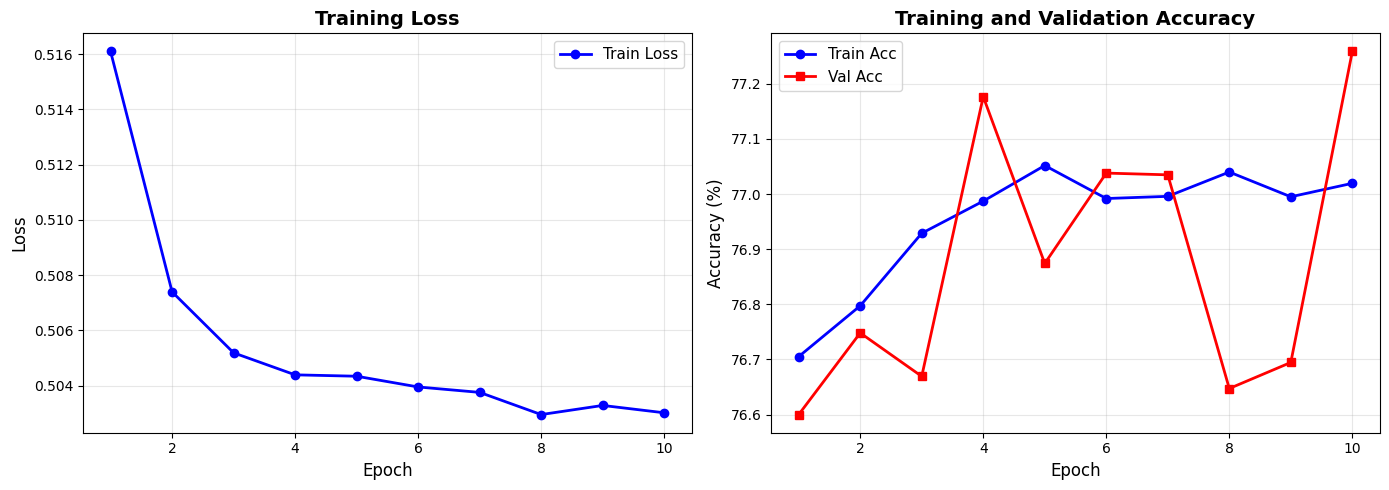

✓ Training plots saved to ./checkpoint_Advance_GCNLayer_V2/training_metrics.png


In [12]:
if __name__ == "__main__":
    
    device = ''
    if torch.cuda.is_available():
        device = 'cuda' # Get the name of the first GPU (index 0)
    else:
        device = 'cpu'

        
    # Initialize model
    model = JetClassifierGNN(num_node_features=15, hidden_dim=32, num_classes=2, use_batch_norm=True)
    
    # Print model summary
    print(f"\nModel parameters: {sum(p.numel() for p in model.parameters())}")
    print("\nModel architecture:")
    print(model)
    
    # Now train on real data
    trained_model, metrics = train_model(
                                        model=model,
                                        num_epochs=10,
                                        device=device,
                                        save_dir='./checkpoint_Advance_GCNLayer_V2',
                                        val_split=0.2,  # 80% train, 20% validation
                                        batch_size=32
                                        )
    


# Load Model

In [ ]:
def load_best_model(model_class, checkpoint_path, device='cpu'):
    """
    Load the best saved model.
    
    Args:
        model_class: Model class (e.g., JetClassifierGNN)
        checkpoint_path: Path to the checkpoint file
        device: Device to load model on
    
    Returns:
        model: Loaded model
        checkpoint: Checkpoint dictionary with metrics
    """
    # Initialize model
    model = model_class(
        num_node_features=15,
        hidden_dim=32,
        num_classes=2,
        use_batch_norm=True
    )
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"✓ Model loaded from {checkpoint_path}")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Val Accuracy: {checkpoint['val_acc']:.2f}%")
    
    return model, checkpoint
